In [77]:
import matplotlib.pyplot as plt
plt.rc('font', family="Malgun Gothic")

In [2]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianMTModel, MarianTokenizer # translation machine
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange

DEVICE = "GPU" if torch.cuda.is_available() else "CPU"
print(DEVICE)

c:\Users\hoya9\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU


In [3]:
# for reproducibility
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # Multi-GPU case
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [4]:
# Load the tokenizer & model
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en') # MT: Machine Translation

In [5]:
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print('eos_idx = ', eos_idx)
print('pad_idx = ', pad_idx)

eos_idx =  0
pad_idx =  65000


## 하이퍼파라미터 조정

In [6]:
BATCH_SIZE = 64 # 실제 논문에선 2.5만 token이 한 batch에 담기게 했다고 함
LAMBDA = 0 # l2-Regularization를 위한 hyperparams (저장된 모델)
EPOCH = 15 # 저장된 모델
max_len = 100 # 길이 제한 (GPU 부담도 많이 감소)
"""
decoder에서 모델이 <eos>가 출력되는 것까지는 Loss를 구하고,
그뒤 <pad>에 대한 Loss는 무시하기 위한 역활
즉, label이 <pad> 일 때는 무시
"""
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

scheduler_name = 'Noam' # Transformer 논문 제 2저자가 제안한 learning rate scheduler
scheduler_name = 'Cos'
#### Noam ####
# warmup_steps = 4000 # 실제 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1000 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 (저장된 모델)
LR_scale = .5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 값 (저장된 모델)
#### Cos ####
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐 (1보다 큰 정수여야 함)
#############

"""
나만의 모델을 만들고 싶으면,
new_model_train = True
prev_model_use = False
"""
new_model_train = False
prev_model_use = True

!mkdir data

if prev_model_use:
    !gdown https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2 -O data/Transformer_small.pt
    !gdown https://drive.google.com/uc?id=1M0yYP2umxlwaAbk_iq5G_Z5y3qLu9Wet -O data/Transformer_small_history.pt

    save_model_path = 'data/Transformer_small.pt'
    save_history_path = 'data/Transformer_small_history.pt'
else:
    save_model=path = 'data/Transformer_small2.pt'
    save_history_path = 'data/Transformer_small2_history.pt'

A subdirectory or file data already exists.
Downloading...
From (original): https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2
From (redirected): https://drive.google.com/uc?id=1bjbeWgqlVKJ9gzDcL1hfD9cIItQy9_N2&confirm=t&uuid=6e6e21aa-0449-4743-bca5-c7c6f69f607a
To: c:\Users\hoya9\OneDrive\Desktop\torch-gpu\Workspace\Transformer-pytorch\data\Transformer_small.pt

  0%|          | 0.00/448M [00:00<?, ?B/s]
  0%|          | 524k/448M [00:00<02:39, 2.82MB/s]
  1%|          | 2.62M/448M [00:00<00:44, 9.98MB/s]
  2%|▏         | 7.34M/448M [00:00<00:21, 20.7MB/s]
  2%|▏         | 9.96M/448M [00:00<00:19, 22.4MB/s]
  3%|▎         | 14.7M/448M [00:00<00:14, 29.3MB/s]
  4%|▍         | 17.8M/448M [00:00<00:14, 29.0MB/s]
  5%|▍         | 21.0M/448M [00:00<00:16, 25.3MB/s]
  5%|▌         | 24.1M/448M [00:01<00:16, 25.7MB/s]
  6%|▌         | 27.3M/448M [00:01<00:18, 23.2MB/s]
  7%|▋         | 31.5M/448M [00:01<00:15, 27.5MB/s]
  8%|▊         | 34.6M/448M [00:01<00:19, 21.5MB/s]
  9%|▊

In [7]:
"""
논문에 나오는 BASE MODEL
train loss를 많이 줄이려면 많은 epoch이 요구됨.
test 성능도 높이려면 더 많은 데이터가 필요함
"""
n_layers = 6
d_model = 512
d_ff = 2048
n_heads = 8
drop_p = .1

# 좀 사이즈 줄인 모델 (훈련된 input_embedding, fc_out 사용하면 사용 불가)
n_layers = 3
d_model = 26
d_ff = 512
n_heads = 8
drop_p = .1

## 토크나이저 & 학습된 모델 써보기

In [8]:
# tokenizer 써보기 (_로 띄어쓰기를 나타낸다! 즉, _가 없으면 이어진 한 단어 : subword tokenizing)
# tokenizer에 대한 참고 자료: https://ratsgo.github.io/nlpbook/docs/preprocess/bpe/
print(tokenizer.tokenize("Hi, I'm Ian. ... a  a?"))
print(tokenizer.tokenize('a/b 1+2+3 2:1 a>b'))
print(tokenizer.tokenize('pretrained restart'))
print(tokenizer.tokenize('chatGPT'))
print(tokenizer.tokenize('The example is very good in our lecture'))
print(tokenizer.tokenize('한글은 어떻게 할까?'))
print(tokenizer.tokenize('확실히 띄어쓰기 기준으로 토크나이징을 하는 것 같진 않다.'))
print(tokenizer.tokenize('여러분 차례!'))

['▁H', 'i', ',', '▁I', "'", 'm', '▁I', 'an', '.', '▁', '...', '▁a', '▁a', '?']
['▁a', '/', 'b', '▁1', '+2', '+3', '▁2:', '1', '▁a', '>', 'b']
['▁p', 're', 'tra', 'in', 'ed', '▁re', 'st', 'art']
['▁ch', 'at', 'G', 'P', 'T']
['▁The', '▁', 'ex', 'am', 'ple', '▁is', '▁', 'very', '▁good', '▁in', '▁', 'our', '▁', 'le', 'c', 'ture']
['▁한', '글', '은', '▁어떻게', '▁할까', '?']
['▁확실히', '▁띄', '어', '쓰기', '▁기준으로', '▁토', '크', '나이', '징', '을', '▁하는', '▁것', '▁같', '진', '▁않다', '.']
['▁여러분', '▁차례', '!']


In [9]:
# print(tokenizer.get_vocab()) # tokenizer에 들어있는 모든 토큰과 토큰의 해당하는 번호를 dict으로 가짐
vocab_size = tokenizer.vocab_size
print((vocab_size))

# add_special_token은 <eos> 자동 붙여주는 것을 방지
print(tokenizer.encode('지능', add_special_tokens=False))   # string to index
print(tokenizer.encode('<pad>', add_special_tokens=False))  # <pad>는 65000
print(tokenizer.encode('</s>', add_special_tokens=False))   # <sos> or <eos>는 0
print(tokenizer.encode('He', add_special_tokens=False))
print(tokenizer.encode('he', add_special_tokens=False))     # 대소문자 다른 단어로 인식
print(tokenizer.tokenize('문장을 넣으면 tokenize해서 숫자로 바꾼다'))
print(tokenizer.encode('문장을 넣으면 tokenize해서 숫자로 바꾼다', add_special_tokens=False))
print(tokenizer.decode([204]))
print(tokenizer.decode([206]))
print(tokenizer.decode([210]))
print(tokenizer.decode(list(range(15)) + [65000, 65001, 65002, 65003]))

65001
[34359]
[65000]
[0]
[125]
[59]
['▁문장', '을', '▁넣으면', '▁to', 'k', 'en', 'ize', '해서', '▁숫자', '로', '▁바꾼', '다']
[13774, 51, 40068, 5, 1479, 1252, 5016, 969, 6635, 131, 30737, 161]
사람
으로
make
</s> <unk> ., the to of? and s a' in 들<pad> <unk> <unk> <unk>


In [10]:
# 사전 학습된 모델로 번역
input_text = "지금 너무 배고프다... 치킨먹고 싶다!"

input_tokens = tokenizer.encode(input_text, return_tensors="pt")    # 모델에서 weight와 행렬곱을 하기 위해 2차원 벡터로 변경경
translated_tokens = model.generate(input_tokens, max_new_tokens=max_len)    # max_len까지만 출력
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)  # <pad> </s> <unk> 같은 특수 토큰은 출력에서 제외외

print("입력:", input_text)
print("번역 결과:", translated_text)

입력: 지금 너무 배고프다... 치킨먹고 싶다!
번역 결과: I'm so hungry right now... and I want chicken!


In [13]:
# data download
# https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=126 데이터 경로
!gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O data/dialogue.xlsx
data = pd.read_excel('data/dialogue.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: c:\Users\hoya9\OneDrive\Desktop\torch-gpu\Workspace\Transformer-pytorch\data\dialogue.xlsx

  0%|          | 0.00/9.57M [00:00<?, ?B/s]
  5%|▌         | 524k/9.57M [00:00<00:02, 3.02MB/s]
 27%|██▋       | 2.62M/9.57M [00:00<00:00, 10.8MB/s]
 49%|████▉     | 4.72M/9.57M [00:00<00:00, 13.9MB/s]
100%|██████████| 9.57M/9.57M [00:00<00:00, 19.9MB/s]


In [16]:
print(data.shape)
print(data.head(3))

(100000, 7)
    대분류 소분류       상황  Set Nr.  발화자                            원문  \
0  비즈니스  회의  의견 교환하기        1  A-1   이번 신제품 출시에 대한 시장의 반응은 어떤가요?   
1  비즈니스  회의  의견 교환하기        1  B-1    판매량이 지난번 제품보다 빠르게 늘고 있습니다.   
2  비즈니스  회의  의견 교환하기        1  A-2  그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.   

                                                 번역문  
0  How is the market's reaction to the newly rele...  
1  The sales increase is faster than the previous...  
2  Then, we'll have to call the manufacturer and ...  


In [17]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000])
# 논문에서는 450만개 영, 독 문장 pair 사용

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


In [20]:
# test_DS 확인
i = 5
src_text, trg_text = test_DS[i]

print(f"인덱스: {test_DS.indices[i]}")   # 원본 데이터에서의 인덱스 추척
print(f"원문: {src_text}")
print(f"영문: {trg_text}")

인덱스: 19993
원문: 나도 그랬으면 좋겠지만 겨울까지 휴가 못 가.
영문: I wish I could, but I can't go on vacation until winter.


In [22]:
# train_DL TEST
for src_texts, trg_texts in train_DL:
    print(src_texts)
    print(trg_texts)
    print(len(src_texts))
    print(len(trg_texts))


    # 여러 문장에 대해서는 tokenizer.encode() 가 아닌 그냥 tokenizer()사용
    # add_special_tokens = True (default)면 <eos>를 붙임
    # truncation = True: max_len 보다 길면 끊음
    src = tokenizer(src_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=False).input_ids
    # <sos>가 tokenizer에 따로 없어서 </s> 를 <sos> 로서 사용
    trg_texts = ['</s> '+ s for s in trg_texts]
    trg = tokenizer(trg_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=True).input_ids

    print(src[:2])
    print(trg[:2])
    print(src.shape)
    print(trg.shape)
    print(trg[:,-1])    # 가장 마지막 단어를 보니 어떤 문장은 <eos> 로 끝이 났고 나머지는 <pad> 로 끝이 났다는 걸 볼 수 있음
    print(tokenizer.decode(trg[trg[:,-1]==eos_idx,:][0]))   # 가장 긴 문장들 중 첫 번째 문장 관찰
    print(trg[5,:-1])  # 디코더 입력
    print(trg[5,1:])   # 디코더 출력으로 나와야 할 label
    # 어차피 출력으로 pad token이 기다리고 있으니 loss에서 ignore로 인해 다 무시되므로 eos가 들어가도 상관없음

    break

('어서 오세요. 환전 도와드리겠습니다. 여권 보여주시겠어요?', '너희 표는 어디에서 구했냐? 난 찾다가 포기했는데.', '건너편에서 항구행 버스를 타시면 금방 갈 겁니다.', '오늘이 우리 5주년 기념일인 거 잊지 않았지?', '어댑터만 따로 판매하고 있지 않습니다.', '제가 아는 소프트웨어 프로그래머가 있는데 추천할만한 프로그램이 있는지 물어볼게요.', '내 말이 그 말이야. 인터넷 면세점으로 구매한 물건도 받으러 가야 하는데.', '751이나 740 버스를 타면 정문 앞에서 내려줘요.', '저희 헬스장에 댄스 프로그램이 있으니 그걸 같이 들어보시면 될 것 같아요.', '키랑 몸무게가 어떻게 되는지 아세요?', '돈가스 포장해주세요, 6분 뒤에 가지러 올게요.', '퇴사라는 어려운 결정을 하셨는데, 사유가 무엇인지 말씀해주시겠습니까?', '그럼 내가 여기선 찌개를 사고 후식을 사도록 할게.', '차고지 앞 정류장에서 버스를 타시면 됩니다.', '소설의 장면들을 어떻게 풀어나갈지 정말 궁금해.', '하지만 소셜 미디어에서도 반응이 좋은데요.', '우선 문제가 뭔지 정확하게 말해 주시면 고맙겠습니다.', '혹시 몇 번 상영관이었는지 기억하시나요?', '졸업식 끝나고 외식을 하려는데, 뭐 먹고 싶은 거 있나요?', '이번 주에 신제품 관련해서 홍보팀 회의 일정을 잡아주시겠어요?', '이 원피스는 가을 느낌이 나는데, 여름 느낌이 나는 원피스는 없나요?', '보니까 아예 화면 대부분이 안 보이는 상태인데, 혹시 떨어뜨리셨나요?', '대학병원에서는 당일 접수가 어렵습니다.', '아니 무슨 날은 아니고, 그냥 분위기 전환 삼아 꾸며봤어.', '잠시만요, 지금 앞에 환자가 많이 밀려있어서요.', '항생제를 함께 처방해주셨는데, 염증이 심하신가 봐요?', '아니요, 유럽 전문 인솔자가 공항에서부터 동행합니다.', '이메일이 전송되고 원하신다면 문자를 보내 드릴 수도 있어요.', '감사합니다, 여성 인권도 다양한 분야가 있는데 어떠한 부분으로 할까요?', '그렇군요. 

In [24]:
# 내가 쓸 train data 에 대해서 MarianMTmodel이 잘 번역하는지 확인
src_text, trg_text = test_DS[5]
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

src = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens=True)
# add_special_tokens = False 해보면 뭔가 이상하게 번역함 (학습 때 source에도 <eos>를 넣었단 증거?)
translated_tokens = model.generate(src, max_new_tokens=max_len)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=False)

print(f"AI의 번역: {translated_text}")  # 디코더 첫 입력으로 <pad> 토큰을 넣었음. (<pad>를 <sos>로 사용)


입력: 나도 그랬으면 좋겠지만 겨울까지 휴가 못 가.
정답: I wish I could, but I can't go on vacation until winter.
AI의 번역: <pad> I wish I could, but I can't go on vacation until winter.</s>


## 모델 구현

### Multi-Head Attention

In [92]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, Q, K, V, mask=None):

        Q = self.fc_q(Q) # 개단차
        K = self.fc_k(K)
        V = self.fc_v(V)

        Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads) # 개단차 -> 개헤단차
        K = rearrange(K, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads)
        V = rearrange(V, '개 단 (헤 차) -> 개 헤 단 차', 헤=self.n_heads)

        attention_score = Q @ K.transpose(-2,-1)/self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10

        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        X = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
        x = self.fc_o(X) # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p), # 논문에는 명시하진 않았지만, overfitting에 취약한 부분이기 때문에 추가
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

In [81]:
Q = torch.randn(1, 4, 6)    # 개단차
print(Q)

Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤=3)  # 개단차 -> 개헤단차
# 주의! (차 헤)로 해보면 나뉜 데이터가 또 다름. 차원의 수 6을 헤드의 수 3으로 쪼개는 것이므로 (헤 차) 가 맞다.
print(Q)
print(Q.shape)

x = rearrange(Q, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
print(x)
print(x.shape)

tensor([[[ 0.2609, -0.1564,  1.0209,  0.8718, -0.2815,  0.1682],
         [-0.7080,  1.2521, -0.9203,  0.6306,  0.2587,  0.9545],
         [ 0.4578,  0.0594,  0.8591,  1.5593, -1.3450,  0.5248],
         [ 1.4705, -0.2618, -0.6434,  1.4521,  1.8436, -0.3093]]])
tensor([[[[ 0.2609, -0.1564],
          [-0.7080,  1.2521],
          [ 0.4578,  0.0594],
          [ 1.4705, -0.2618]],

         [[ 1.0209,  0.8718],
          [-0.9203,  0.6306],
          [ 0.8591,  1.5593],
          [-0.6434,  1.4521]],

         [[-0.2815,  0.1682],
          [ 0.2587,  0.9545],
          [-1.3450,  0.5248],
          [ 1.8436, -0.3093]]]])
torch.Size([1, 3, 4, 2])
tensor([[[ 0.2609, -0.1564,  1.0209,  0.8718, -0.2815,  0.1682],
         [-0.7080,  1.2521, -0.9203,  0.6306,  0.2587,  0.9545],
         [ 0.4578,  0.0594,  0.8591,  1.5593, -1.3450,  0.5248],
         [ 1.4705, -0.2618, -0.6434,  1.4521,  1.8436, -0.3093]]])
torch.Size([1, 4, 6])


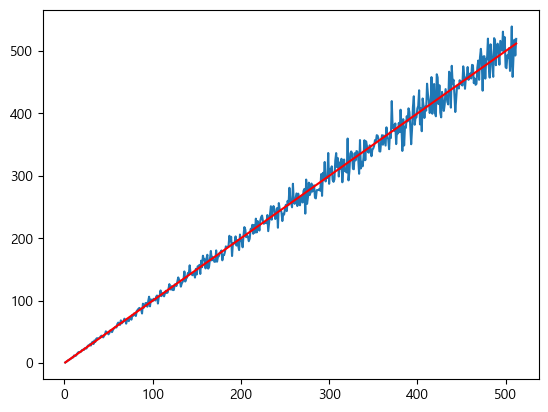

In [91]:
# scaling을 sqrt(dk)로 하는 이유 : 안나누면 softmax로 들어갈때 분산이 커져 grad가 작아짐
n = torch.arange(1, 513)
N = 1000
result = []
for ni in n:
    inner_prod = torch.zeros(N)
    for i in range(N):
        inner_prod[i] = torch.randn(ni,1).T@torch.randn(ni,1)   # inner product
    result += [torch.var(inner_prod)]

plt.plot(n,result)
plt.plot(n,n,'r') # 즉, dk가 커지면 variance도 같이 커지니깐 std(sqrt(dk))로 나눠서 dk가 함수가 아니도록 하는 것! (분산은 데이터 개수에 따라 값이 커지기도 하기 때문에)

### Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten = MHA(d_model, n_heads)
        self.self_atten_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, drop_p)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual, atten_enc = self.self_atten(x, x, x, enc_mask) # pad masking
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()




